He visto que dedicais demasiadas horas a las practicas. Recuerdo la regla intentais pasar un maximo de 2h.
A partir de ahora, cambiamos un poco los criterios de avaluacion, hasta ahora yo miraba si funcionava, si habiais hecho el trabajo. Pero a partir de ahora intentaremos sobre todo programar "bien", es decir seguir las siguientes reglas:
    - comentarios: codigo comentado para que se entienda, los comentarios tienen que ser presentes pero tambien ser concisos para evitar sobre caregar inutilmente el codigo
    - nombre de variables explicito: elegir con cuidado los nombres de variable para que el codigo sea facil de entender
    - Optimizacion: Intentaremos no hacer trabajar el ordenador inutilmente, es decir, utilizar numpy si es possible en ves de las loops, no hacer loops inutiles, no escribir lineas inutiles (por ejemplo incrementar el contador dentro de un for).
    - simple es mejor que complicado: a veces mejor buscar un poco mas una manera sencilla y elegante de hacer las cosas es mejor que escribir toneladas de for, de if, y de while
    - escribir funciones: cuando teneis que repetir una operacion varias veces, mejor hacer una funcion. No olvidar escribir la documentacion de la funciones
    - Hardcoded prohibido: poner los numeros en variables, nunca hacer un print y copiar el valora mano. (excepto por los nombre de varible de los fichieros netcdf y para definir el rango de una figura).
    - Control de error: Es mejor cuando se escriba una funcion pensar a comprovar que los arguementos esten bien, por ejemplo sus dimensiones, comprovar que los fichieros existen...

Sigo poniendo 2 niveles de dificuldad y un tiempo estimado

## Que controla la precipitaciones en hivierno?

### Part 1 - Tendencia (facil - 7pt)

1) Leer el fichiero de precipitacion de GPCP sobre Europa (https://www.esrl.noaa.gov/psd/data/gridded/data.gpcp.html). Utilizando el servidor Opendab o descargando el fichiero. Convertir los valores en mm/day. (tiempo max: 25min - 1 pt)

In [1]:
#import netcdf library
from netCDF4 import Dataset as nc 
#import date conversor netcdf
from netCDF4 import num2date, date2num 
from datetime import date, timedelta, datetime
import numpy as np
import os
from scipy import stats
import sys

In [23]:
file = nc("precip.mon.mean.nc", "r")
file.variables

OrderedDict([('lat', <class 'netCDF4._netCDF4.Variable'>
              float32 lat(lat)
                  units: degrees_north
                  actual_range: [ 88.75 -88.75]
                  long_name: Latitude
                  standard_name: latitude
                  axis: Y
              unlimited dimensions: 
              current shape = (72,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('lon', <class 'netCDF4._netCDF4.Variable'>
              float32 lon(lon)
                  units: degrees_east
                  long_name: Longitude
                  actual_range: [  1.25 358.75]
                  standard_name: longitude
                  axis: X
              unlimited dimensions: 
              current shape = (144,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('time_bnds', <class 'netCDF4._netCDF4.Variable'>
              float32 time_bnds(time, nv)
                  comment: time

In [2]:
def read_var_from_file (file_name, variable, lon_lat, lon_lat_name):
    """
    function that reads a file, and limits a variable to a 
    region of the earth globe (latitude and longitude)
    file_name: name of the file (as saved in the folder)
    variable: name of the variable that has to be boxed
    lon_lat: Boundaries of latitude and longitude for the region studied (box)
    lon_lat_name: Array of the names that the file uses for "latitude" and "longitude" variables
    """
    # firstly the file is read
    try :
        file = nc(file_name, "r") # open the netcdf file 
    except:
        print("el fichiero "+file_name+" no existe.")
        sys.exit(1)
    # read time axis
    if "time" in file.variables.keys():
        timevar = file.variables["time"]
    else:
        print("no variable time in the file")
        sys.exit(1)
        
    dates = num2date(timevar[:], units=timevar.units) 
    
    # read longitude
    if lon_lat_name[0] in file.variables.keys():    
        lon = file.variables[lon_lat_name[0]][:]
    else:
        print("no variable",lon_lat_name[0], "in the file")
        sys.exit(1)
    # read latitude
    if lon_lat_name[1] in file.variables.keys():    
        lat = file.variables[lon_lat_name[1]][:]
    else:
        print("no variable", lon_lat_name[1], "in the file")
        sys.exit(1)
    # check the existence and the dimension of 'variable'
    if not(variable in file.variables.keys()):
        print("no variable "+variable+" in the file")
        sys.exit(1)
    # check the dimension of the variable shape
    elif len(file.variables[variable].shape)!=3:
        print("This function is done to read varable of size 3")
        sys.exit(1)
    # limit the years of data in order to fit the geopotential data shape with the      
    fullyear = np.where(dates<datetime(year=2019, month=1, day=1))[0]
    dates = dates[fullyear]

    # Make all the longitudes fall in the range of 0-360 degrees 
    # As the files don't have longitude organized from -180 to 180 deg
    lon_lat = np.array(lon_lat)
    lon_lat[:2] = (lon_lat[:2] + 360)%360
    
    # Bound the latitude between the latitude boundaries
    lat_box = np.where((lat > lon_lat[2])&(lat < lon_lat[3]))[0]
    lat = lat[lat_box]
    
    if lon_lat[0]>lon_lat[1]:
        # calculate values at the west of Greenwitch
        lon_box1 = np.where((lon >= lon_lat[0]))[0]
        # calculate values at the east of Greenwitch
        lon_box2 = np.where((lon <= lon_lat[1]))[0]
        # extract data for the west of Greenwitch
        geo_box1 = file.variables[variable][:,lat_box,lon_box1]
        # extract data for the east of Greenwitch
        geo_box2 = file.variables[variable][:,lat_box,lon_box2]
        # concatenate both extracted data into a single box
        geo_box_var = np.concatenate((geo_box1, geo_box2), axis=2)
        lon = np.concatenate((lon[lon_box1], lon[lon_box2]), axis = 0)
    else:
        # Bound the longitude between the longitude boundaries
        lon_box = np.where((lon >= lon_lat[0])&(lon <= lon_lat[1]))[0]
        # create a data varaible inside the box defined
        geo_box_var = file.variables[variable][fullyear,lat_box,lon_box]
        lon = lon[lon_box]
        
    # definition of the number of years that will be considered
    nyear = int(len(fullyear)/12)
    geo_box_var = geo_box_var[fullyear,:,:]
    
    return (geo_box_var, dates, lon, lat, nyear)

In [3]:
# Box of Latitude and Longitude for Europe (lon1, lon2, lat1, lat2)
lon_lat = [-25, 45, 30, 80]
# The variables latitude and longitude are referenced with the following names 
lon_lat_name = ["lon","lat"]
variable_name = "precip"
urlbase = "https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/gpcp/"
filename = urlbase+"precip.mon.mean.nc" 
filename = "precip.mon.mean.nc" 
precip, dates, lon, lat, nyear = read_var_from_file(filename,variable_name,lon_lat,lon_lat_name)
# reshape the data to months and years 
precip.shape =(nyear, 12, len(lat), len(lon))
# reshape the dates structure to years and months
dates.shape = (nyear, 12)

In [4]:
precip.shape

(40, 12, 20, 28)

2) Escribir una funcion que calcula las anomalias y calcular las anomalias de precipitaciones (tiempo max: 30min - 2pt)

In [5]:
def anomaly (var):
    """
    function that calculates the anomaly and the mean for a series
    of data.
    var = variable name that the user wants to use
    """
    # mean of the variable
    mean_var = np.mean(var, axis = 0) 
    # expand the mean to an array with the same shape as the var array.
    expan_mean_var = np.expand_dims(mean_var, axis=0).repeat(var.shape[0], axis=0)
    # print(var.shape,expan_mean_var.shape)
    # differentiating both arrays the anomaly is found
    anom = var - expan_mean_var
    return(anom,mean_var)

In [6]:
anom, mean_var = anomaly(precip)

In [7]:

anom[0:(nyear-1),[11],:,:].shape, anom[1:,[0,1],:,:].shape,nyear


((39, 1, 20, 28), (39, 2, 20, 28), 40)

3) Calcular la media estacional de la precipitaciones en verano (June Julio Agosto) y hivierno (Decembre Enero Febrero, cuidado teneis que juntar los meses seguidos, por ejemplo Decembre 1993 con Enero 1994 y Febrero 1994) (30min - 2pt)

In [8]:
# anomaly just for June, July & August months
anomJJA = np.mean(anom[:,[5,6,7],:,:], axis = 1)
# anomaly just for December, January & February months
# To do it, it must be taken into account that december is from teh previous year
# create an array with the months we want to make the mean from
DJF = []
for i in range(nyear-1):
    DJF.append(anom[i,11,:,:])
    DJF.append(anom[i+1,0,:,:])
    DJF.append(anom[i+1,1,:,:])
# convert it to numpy
DJF_np = np.array(DJF)
# shape it so that it has nyear-1 and 3 months i.e. DJF
DJF_np.shape = (nyear-1, 3, len(lat), len(lon))
anomDJF = np.mean(DJF_np, axis = 1)

3) Calcular la tendencia de la precipitacion en verano y hiverno (30 min - 2 pt)

In [9]:
def trend_r_pv (anom, lat, lon, x):
    """
    function that calculates the trend, the score and the pvalue 
    of a given period of time.
    anom = anomaly of the variable through time
    lat = latitudes defined
    lon = longitudes defined
    nyear = number of years used
    x = variable used in the x axis of the correlation
    """
    #two arrays to save the trend, score and pvalue
    trend = np.zeros((len(lat), len(lon)))
    r = np.zeros((len(lat), len(lon)))
    pvalue = np.zeros((len(lat), len(lon)))

    # for that finds the slope of the linear regression, r and pvalue
    for ilat in range(len(lat)):
        for ilon in range(len(lon)):
            linreg = stats.linregress(x,anom[:,ilat,ilon])
            trend[ilat, ilon] = linreg.slope
            r[ilat, ilon] = linreg.rvalue
            pvalue[ilat, ilon] = linreg.pvalue
    return(trend, r, pvalue)

In [10]:
from sklearn.linear_model import LinearRegression
# trend, score and pvalue caluclation for JJA months
trendJJA, rJJA, pvalueJJA = trend_r_pv (anomJJA, lat, lon, np.arange(nyear))
# trend, score and pvalue caluclation for DJF months
trendDJF, rDJF, pvalueDJF = trend_r_pv (anomDJF, lat, lon, np.arange(nyear-1))

In [11]:
from sklearn.linear_model import LinearRegression
# x contains all the years of data
x = np.arange(nyear)
# y contains all the years of data -1 because using winter we lose a year of data
y = np.arange(nyear-1)
# linear regression instance creation
model = LinearRegression() 
# fit the trend. Must be two-dim so an extra dim of shape 1 is created
trendJJA = np.array([LinearRegression().fit(x[:, np.newaxis], anomJJA[:,ilat,:]).coef_  for ilat in range(len(lat))]).squeeze()
trendDJF = np.array([LinearRegression().fit(y[:, np.newaxis], anomDJF[:,ilat,:]).coef_  for ilat in range(len(lat))]).squeeze()

4) Hacer los mapas de la tendencia de precipitacion en hiverno y verano, incluendo la pvalue (40min - 3pt)

In [12]:
def plotter (trend, pvalue, lon, lat, bar):
    """
    function that plots the anomalies of a variable in a region.
    trend = trend of the variable series
    pvalue = pvalue of the variable series
    lon = longitude
    lat = latitude
    bar = magnitude color bar definition
    """
    import matplotlib.pyplot as plt
    %matplotlib inline
    #import cartopy for plotting maps
    import cartopy.crs as ccrs
    #create a projection
    data_crs = ccrs.PlateCarree()
    #define a map
    ax = plt.axes(projection=ccrs.PlateCarree())
    #drw coastline
    ax.coastlines()
    #put longitude from -180 to 180
    lon[lon>180]=lon[lon>180]-360
    # create 2d lon lat
    lon2d, lat2d = np.meshgrid(lon, lat)
    #plot
    cs = ax.contourf(lon2d, lat2d, trend, bar, transform=data_crs, cmap=plt.cm.RdBu)
    #put dots where the p.value is significant
    signi = np.where(pvalue<0.01)
    ax.plot(lon2d[signi], lat2d[signi], linestyle='none', marker="o", markersize=0.2)
    # drw color bar
    cbar = plt.colorbar(cs, orientation="horizontal")
    return()

()

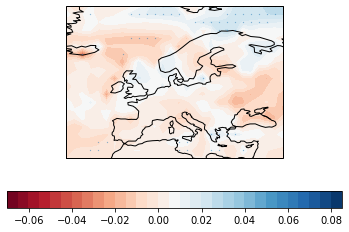

In [13]:
# use function 'plotter' to show the results of the summer precipitation trend. With the pvalue
plotter(trendJJA, pvalueJJA, lon, lat, np.arange(-14,18)/200.)

()

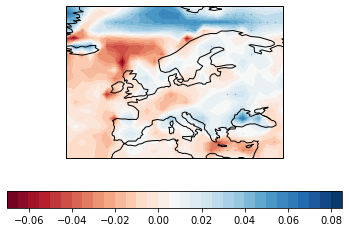

In [14]:
# use function 'plotter' to show the results of the winter precipitation trend. With the pvalue
plotter(trendDJF, pvalueDJF, lon, lat, np.arange(-14,18)/200.)

### small insight on the maps:

 The generalized trend of the summer season is a generalized descent of the precipitation over all the continent with no significant trend extremes. For the winter months there is a higher difference between regions. Sectors with a clear trend to dryness and other other with more precipitation can be seen. 

 Dryer: Galicia, Ireland, North-Atlantic, Aegean sea...
 
 More Precep: Greenland, Polar circle, Black Sea, North-Iceland

### Part 2 - NAO mes dificil (3pt)

3) Leer los datos de geopotential para el calculo de la NAO https://www.youtube.com/watch?v=KOYJG7j4Iy8 - Norte punto alrededor de -25ºW, 65ºN y cara sur alrededor de -25ºW y 35ºN

In [15]:
def read_var_from_file_4 (file_name, variable, lon_NOA,lat_N_NOA,lat_S_NOA,lev):
    """
    function that reads a file, and limits a variable to a 
    region of the earth globe (latitude and longitude). That variable must be 
    described in different levels. (like with geopotential at diff. pressure levels)
    file_name: name of the file (as saved in the folder)
    variable: name of the variable that has to be boxed
    lon_lat: Boundaries of latitude and longitude for the region studied (box)
    lon_lat_name: Array of the names that the file uses for "latitude" and "longitude" variables
    lev = pressure level where teh data will be extracted from
    """
    # firstly the file is read
    try :
        file = nc(file_name, "r") # open the file 
    except:
        print("el fichiero "+file_name+" no existe.")
        sys.exit(1)
    # the time of the axis is read
    if "time" in file.variables.keys():
        timevar = file.variables["time"]
    else:
        print("no variable time in the file")
        sys.exit(1)
        
    dates = num2date(timevar[:], units=timevar.units) 
    
    # longitude is read
    if "lon" in file.variables.keys():    
        lon = file.variables["lon"][:]
    else:
        print("no variable 'lon' in the file")
        sys.exit(1)
        
    # latitude is read
    if "lat" in file.variables.keys():    
        lat = file.variables["lat"][:]
    else:
        print("no variable 'lat' in the file")
        sys.exit(1)
    # check the existence and the dimension of varname
    if not(variable in file.variables.keys()):
        print("no variable "+variable+" in the file")
        sys.exit(1)
    # check the dimension of the variable shape
    elif len(file.variables[variable].shape)!=4:
        print("This function is done to read varable of size 3")
        sys.exit(1)
    # check existence of the 'level' variable
    if not("level" in file.variables.keys()):
        print("no variable 'level' in the file")
        sys.exit(1)
        
    # limit the years of data in order to fit the geopotential data shape with the     
    fullyear = np.where((dates>=datetime(year=1979, month=1, day=1)) & (dates<datetime(year=2019, month=1, day=1)))[0]
    dates = dates[fullyear]


    # Make all the longitudes fall in the range of 0-360 degrees 
    # As the files don't have longitude organized from -180 to 180 deg
    lon_NOA = np.array(lon_NOA)
    lon_NOA = (lon_NOA + 360)%360
    
    # As the user may not know if the exact value for 'lat' is in the data series a bound of 2º is defined
    # lat_:_NOA-1 and lon_:_NOA+1
    lat_ind_N = np.where((lat >= lat_N_NOA-1)&(lat <= lat_N_NOA+1))[0]
    lat_ind_S = np.where((lat >= lat_S_NOA-1)&(lat <= lat_S_NOA+1))[0]
    latN = lat[lat_ind_N]
    latS = lat[lat_ind_S]
    
    # limit the data to one specific pressure level: 'lev'
    level = file.variables["level"][:]
    level_ind = np.where(level == lev)[0]
    
    # As the user may not know if the exact value for 'lon' is in the data series a bound of 2º is defined
    # lon_NOA-1 and lon_NOA+1
    lon_ind_NnS = np.where((lon >= lon_NOA-1)&(lon <= lon_NOA+1))[0]
    lon_NnS = lon[lon_ind_NnS]
    # create a data varaible with the parameters defined
    geo_var_N = file.variables[variable][fullyear,level_ind,lat_ind_N,lon_ind_NnS]
    geo_var_S = file.variables[variable][fullyear,level_ind,lat_ind_S,lon_ind_NnS] 
    
    # definition of the number of years that will be considered
    nyear = int(len(fullyear)/12)
    
    return (geo_var_N, geo_var_S, dates, lon_NnS, latN, nyear)

In [16]:
# The caracteristic latitudes and longitudes for the NOA are defined
lonNS = -25;
latN = 65
latS = 35
# The variables latitude and longitude are referenced with the following names 
variable_name = "hgt"
filename = "hgt.mon.mean.nc"
# pressure level where the data will be extracted from
lev = 500

geopot_N, geopot_S, dates, lon2, lat2, nyear_NAO = read_var_from_file_4(filename,variable_name,lonNS,latN,latS,lev)

# reshape the data to months and years 
geopot_N.shape =(nyear_NAO, 12, 1, len(lat2), len(lon2))
geopot_S.shape =(nyear_NAO, 12, 1, len(lat2), len(lon2))
# reshape the dates structure to years and months
dates.shape = (nyear_NAO, 12)

4) Calcular las anomalies de los dos puntos de la NAO. 


In [17]:
# use the predefined function 'anomaly'
anom_hgt_N, mean_var = anomaly(geopot_N)
anom_hgt_S, mean_var = anomaly(geopot_S)

5) Normalizar las anomalies en los dos punto (es decir dividir por la deviation estandard) y hacer la differencia entre las dos series de anomalies - Asi teneis el indice de la NAO. 

In [18]:
# normalized anomalies
anom_norm_N = anom_hgt_N[:]/np.std(anom_hgt_N[:])
anom_norm_S = anom_hgt_S[:]/np.std(anom_hgt_S[:])

6) Calcular la media estacional de la NAO

In [19]:
# calculate the value of the NAO
NAO = anom_norm_S - anom_norm_N

# find the winter NAO average
DJF = []
for i in range(nyear_NAO-1):
    DJF.append(NAO[i,11,:,:])
    DJF.append(NAO[i+1,0,:,:])
    DJF.append(NAO[i+1,1,:,:])
# convert it to numpy
DJF_np = np.array(DJF)
# shape it so that it has nyear-1 and 3 months i.e. DJF
DJF_np.shape = (nyear_NAO-1, 3, len(lat2), len(lon2))
NAO_DJF = np.mean(DJF_np, axis = 1)
NAO_DJF

array([[[-0.35276338]],

       [[ 0.7043404 ]],

       [[-0.27852163]],

       [[ 0.78569525]],

       [[ 2.0729516 ]],

       [[-2.0811462 ]],

       [[-0.9583048 ]],

       [[-0.7320635 ]],

       [[-0.7526271 ]],

       [[ 2.2214766 ]],

       [[ 1.2880356 ]],

       [[ 0.3260382 ]],

       [[-0.40462422]],

       [[ 1.0777501 ]],

       [[ 1.5140306 ]],

       [[ 2.8610373 ]],

       [[-2.8968842 ]],

       [[-1.5462965 ]],

       [[-1.0350469 ]],

       [[ 1.3733886 ]],

       [[ 1.3497885 ]],

       [[-1.1676128 ]],

       [[-0.89942145]],

       [[-0.564974  ]],

       [[-1.573974  ]],

       [[-0.32050028]],

       [[-1.475897  ]],

       [[ 0.48696008]],

       [[ 0.9857745 ]],

       [[-0.35451463]],

       [[-4.6947737 ]],

       [[-2.7171996 ]],

       [[ 1.8875666 ]],

       [[-0.23494776]],

       [[ 1.9658266 ]],

       [[ 3.021837  ]],

       [[ 1.7116513 ]],

       [[-0.29382065]],

       [[ 1.375897  ]]], dtype=float32)

7) Calcular la regression entre los el indice de NAO y los datos de precipitación en hivierno 

In [20]:
# trend, score and pvalue caluclation for DJF months between the NAO and the precipitation
trend_NAO_prec_DJF, r_NAO_prec_DJF, pvalue_NAO_prec_DJF = trend_r_pv (anomDJF, lat, lon, NAO_DJF[:,0,0])

8) Hacer el mapa (incluyendo la pvalue), escribir un pequeño comentario de los que podeis deducir de esta figura. (tiempo max: 20min, 1pt)

()

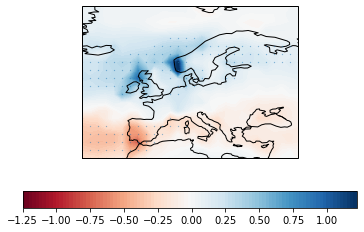

In [21]:
# the same 'plotter' function can be used to plot the NAO-precipitation trend 
# (the range of values represented is modifyed to show all the values)
plotter(trend_NAO_prec_DJF, pvalue_NAO_prec_DJF, lon, lat, np.arange(-50,50)/40.)

A positive NAO is directly related to the precipitation in the west coasts of Ireland, the UK and norwegian coast due to an increased westward wind.

A negative NAO is related to an increase in precipitation in the west of europe due to a smaller west wind component. This allows for the propagation of precipitation to ondulate across europe. 

The correlation of precipitation with positive NAO is stronger than with negative NAO. This might be due to the fact that having a strong west displacement is more limiting to the precipitation propagation path.